In [147]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
import pandas as pd

from synthetic_graph import *
from model_train import TrainModel
from datasets import create_dataset
from simgraph_edges import Ogata_edge
from modules.pwc_markov_fixe_metric import Markov_fixe
# from simgraph import *
# # from cross_validation import *
from metrics import Metrics,multi_to_weight
# from visu import *
# from baseline import *
# import pandas as pdS
# import dgb as dgb
from simgraph_edges import Ogata_edge
from visu import graph_visu, visu_intensity_global, visu_emb,visu_beta
from itertools import combinations


# Creation of synthetic graphs :

In [150]:
features={
    "volume_d": None,
    "common_neighbor_d" : None,
    "pref_att_d" : None
    } 

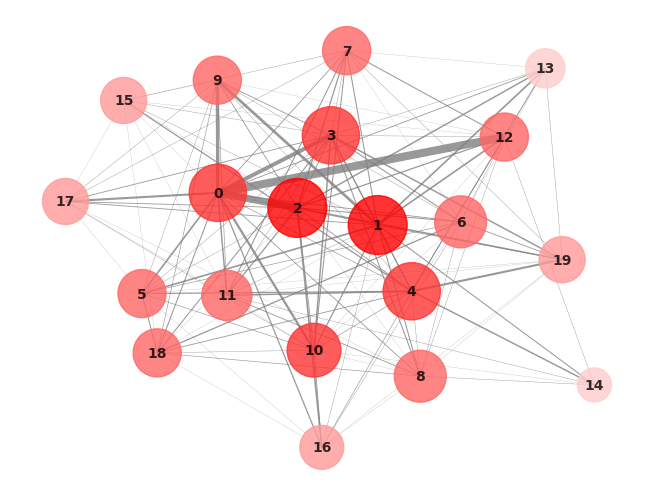

In [151]:
# Configuration model 

nb_node = 20
nb_loop = 20
list_edges = create_config_model(nb_node, nb_loop, poisson = True)

# # SBM-a model 

# nb_node_C1 = 10
# nb_node_C2 = 10
# nb_loop = 20
# list_edges = create_sbm_model(nb_node_C1,nb_node_C2,nb_loop, poisson = True) 

# # SBM-b model 

# nb_node_C1 = 15
# nb_node_C2 = 15
# nb_loop = 20
# list_edges = create_sbm_temp(nb_node_C1,nb_node_C2,nb_loop, poisson = True) 

# # Stream model :

# nb_node = 20
# list_edges = create_stream_model(nb_node)


#########################################################################################

T = 1
min_value = np.min(list_edges[:, -1])
max_value = np.max(list_edges[:, -1])
list_edges[:, -1] = ((list_edges[:, -1] - min_value) / (max_value - min_value))*T
list_edges = [[ min(int(e[0]),int(e[1])) , max(int(e[1]),int(e[0])) , float(e[2])] for e in list_edges]

dataset = create_dataset("affichage", list_edges = list_edges, 
                        features=features
                        )

liste_edges_temps_train = list_edges[:int(len(list_edges)/4*3)]

dataset_train = create_dataset("affichage", list_edges = liste_edges_temps_train, 
                        features=features
                        )

graph_visu(dataset)


# Model training

Epoch 1
-------------------------------
Test Error:  Avg loss: 0.878782 

Epoch 2
-------------------------------
Test Error:  Avg loss: 0.877582 

Epoch 3
-------------------------------
Test Error:  Avg loss: 0.876384 

Epoch 4
-------------------------------
Test Error:  Avg loss: 0.875186 

Epoch 5
-------------------------------
Test Error:  Avg loss: 0.873987 

Epoch 6
-------------------------------
Test Error:  Avg loss: 0.872789 

Epoch 7
-------------------------------
Test Error:  Avg loss: 0.871593 

Epoch 8
-------------------------------
Test Error:  Avg loss: 0.870394 

Epoch 9
-------------------------------
Test Error:  Avg loss: 0.869199 

Epoch 10
-------------------------------
Test Error:  Avg loss: 0.868006 

Epoch 11
-------------------------------
Test Error:  Avg loss: 0.866816 

Epoch 12
-------------------------------
Test Error:  Avg loss: 0.865623 

Epoch 13
-------------------------------
Test Error:  Avg loss: 0.864437 

Epoch 14
-------------------------

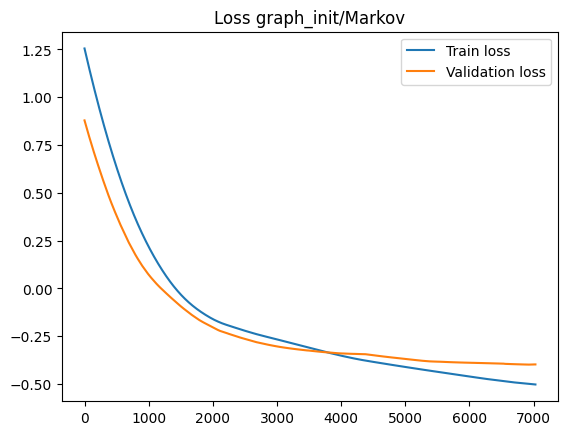

Confusion matrix : 
 [[53  9]
 [28 34]]


In [152]:
model = TrainModel(dataset = dataset_train,
                epoch = 8000,
                nb_feat= 3)

model.train()
model.perf_model()

In [194]:
# visu_emb(dataset, model)
# visu_beta(dataset, model)

# Ogata Simulation

In [154]:
t_last = dataset_train.edge_list[-1][-1]
T = dataset.edge_list[-1][-1]
N = len(dataset.edge_list) -len(liste_edges_temps_train)

ogata = Ogata_edge()
etape, timing = ogata.simu_ogata(dataset_train, t_last, T, N, model.model, features) 
dataset_simu = create_dataset("affichage", list_edges = ogata.dataset_simu.edge_list, 
                        features=features
                        )

# Evaluation Metrics

In [176]:
liste_test = [[row[0], row[1]] for row in dataset.edge_list[int(len(dataset.edge_list)/4*3):]]
liste_train = [[row[0], row[1]] for row in dataset_train.edge_list]
dataset_pred_new =  [element for element in liste_test if element not in liste_train]

list_edges_dataset = dataset.edge_list[int(len(dataset.edge_list)/4*3):] 

dataset_pred = create_dataset("affichage", list_edges = list_edges_dataset, 
                        features=features
                        )

list_edges_simu = dataset_simu.edge_list[int(len(dataset.edge_list)/4*3):] 

dataset_simu_pred = create_dataset("affichage", list_edges = list_edges_simu, 
                        features=features
                        )


model_fixe = Markov_fixe(dataset.n_nodes, beta = 100)          

# Metrics testing
metric = Metrics(dataset_pred)

list_edges = np.array(dataset_simu_pred.edge_list)
min_value = np.min(list_edges[:, -1])
max_value = np.max(list_edges[:, -1])
t1 = dataset_pred.edge_list[0][-1]
t2 = 10

list_edges[:, -1] = t1 + ((list_edges[:, -1] - min_value) / (max_value - min_value)) * (t2 - t1)

list_edges = [[ min(int(e[0]),int(e[1])), max(int(e[1]),int(e[0])), float(e[2])] for e in list_edges]

dataset_simu_pred = create_dataset("affichage", list_edges = list_edges, 
                        features=features
                        )

clust_init, clust_simu, degree_simu = metric.netlsd_clust(dataset_simu_pred)
dtw_global_simu, intensity_edges_simu, intensity_edges, t = metric.dtw(dataset_simu_pred, model_fixe)
evenements_communs_simu,pourcentage_similarite_simu ,evenements_communs_simu_new,pourcentage_similarite_simu_new  =  metric.accuracy(dataset_simu_pred,dataset_pred_new)
nb_event_our = len(dataset_simu_pred.edge_list)

data = [
    ["Ground truth",len(dataset_pred.edge_list), clust_init, 0, 100,len(dataset_pred.edge_list)],
    ["Our",nb_event_our, clust_simu, dtw_global_simu, pourcentage_similarite_simu,evenements_communs_simu]   
]

columns = ["data","#events", "clust", "dtw_global", "accuracy","#common events"]

edges_pred  =  dataset.edge_list[:int(len(dataset.edge_list)/4*3)] + dataset_simu_pred.edge_list

dataset_simu_pred = create_dataset("affichage", list_edges = edges_pred, 
                        features=features
                        )

df = pd.DataFrame(data, columns=columns)
df.head()

,data,#events,clust,dtw_global,accuracy,#common events
0,Ground truth,138,0.370801,0.000000,100.000000,138
1,Our,210,0.377796,331.282605,15.238095,32


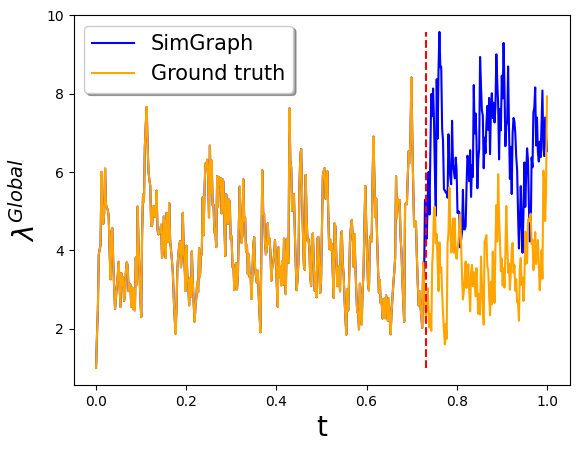

In [177]:
visu_intensity_global(dataset,dataset_simu, model = model_fixe)
